In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
import optuna

In [105]:
# getting simulated data
path = 'data/vehicle_count.csv'
data = pd.read_csv(path)
data.shape

(3728, 49)

In [106]:
# displaying data
first_column = data.columns[0]
data = data.set_index(first_column)
data

,A0A1,A0B0,A1A0,A1A2,A1B1,A2A1,A2A3,A2B2,A3A2,A3B3,...,D0C0,D0D1,D1C1,D1D0,D1D2,D2C2,D2D1,D2D3,D3C3,D3D2
timestep,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3725,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3726,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# checking for null values
data.isnull().sum()

A0A1    0
A0B0    0
A1A0    0
A1A2    0
A1B1    0
A2A1    0
A2A3    0
A2B2    0
A3A2    0
A3B3    0
B0A0    0
B0B1    0
B0C0    0
B1A1    0
B1B0    0
B1B2    0
B1C1    0
B2A2    0
B2B1    0
B2B3    0
B2C2    0
B3A3    0
B3B2    0
B3C3    0
C0B0    0
C0C1    0
C0D0    0
C1B1    0
C1C0    0
C1C2    0
C1D1    0
C2B2    0
C2C1    0
C2C3    0
C2D2    0
C3B3    0
C3C2    0
C3D3    0
D0C0    0
D0D1    0
D1C1    0
D1D0    0
D1D2    0
D2C2    0
D2D1    0
D2D3    0
D3C3    0
D3D2    0
dtype: int64

In [108]:
# preparing input data
x_segments = data.T.copy()
x_segments

timestep,1,2,3,4,5,6,7,8,9,10,...,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728
A0A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0B0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1A0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1A2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2A3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2B2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3A2,0,0,0,0,0,0,0,0,0,0,...,2,1,1,1,1,1,1,1,1,0
A3B3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# getting road segments list
segment_names = x_segments.index.to_list()
print(segment_names)

['A0A1', 'A0B0', 'A1A0', 'A1A2', 'A1B1', 'A2A1', 'A2A3', 'A2B2', 'A3A2', 'A3B3', 'B0A0', 'B0B1', 'B0C0', 'B1A1', 'B1B0', 'B1B2', 'B1C1', 'B2A2', 'B2B1', 'B2B3', 'B2C2', 'B3A3', 'B3B2', 'B3C3', 'C0B0', 'C0C1', 'C0D0', 'C1B1', 'C1C0', 'C1C2', 'C1D1', 'C2B2', 'C2C1', 'C2C3', 'C2D2', 'C3B3', 'C3C2', 'C3D3', 'D0C0', 'D0D1', 'D1C1', 'D1D0', 'D1D2', 'D2C2', 'D2D1', 'D2D3', 'D3C3', 'D3D2']


In [110]:
# calculating the average vehicle count for each road segment
segment_mean_raw = x_segments.mean(axis=1)
print(segment_mean_raw)

A0A1    0.514485
A0B0    0.528702
A1A0    0.603004
A1A2    0.704667
A1B1    2.104345
A2A1    0.720225
A2A3    0.662017
A2B2    2.201180
A3A2    0.705472
A3B3    0.609442
B0A0    0.534603
B0B1    2.159335
B0C0    0.678380
B1A1    1.017972
B1B0    1.113197
B1B2    2.479614
B1C1    2.843079
B2A2    1.060354
B2B1    2.987393
B2B3    1.074303
B2C2    2.504560
B3A3    0.671406
B3B2    1.796942
B3C3    0.781652
C0B0    0.734174
C0C1    2.245708
C0D0    0.587715
C1B1    2.659603
C1C0    1.088519
C1C2    2.642704
C1D1    1.066792
C2B2    2.805526
C2C1    2.690451
C2C3    1.167918
C2D2    1.033262
C3B3    0.651556
C3C2    2.129024
C3D3    0.654506
D0C0    0.668723
D0D1    0.663627
D1C1    2.479077
D1D0    0.701985
D1D2    0.532189
D2C2    1.963788
D2D1    0.724785
D2D3    0.567328
D3C3    0.650483
D3D2    0.671674
dtype: float64


In [111]:
# applying scaling to input values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_segments.values)
x_scaled

array([[-0.14586499, -0.14586499, -0.20851441, ..., -0.14586499,
        -0.14586499,  0.        ],
       [-0.14586499, -0.14586499, -0.20851441, ..., -0.14586499,
        -0.14586499,  0.        ],
       [-0.14586499, -0.14586499, -0.20851441, ..., -0.14586499,
        -0.14586499,  0.        ],
       ...,
       [-0.14586499, -0.14586499, -0.20851441, ..., -0.14586499,
        -0.14586499,  0.        ],
       [-0.14586499, -0.14586499, -0.20851441, ..., -0.14586499,
        -0.14586499,  0.        ],
       [-0.14586499, -0.14586499, -0.20851441, ..., -0.14586499,
        -0.14586499,  0.        ]])

In [112]:
# preparing the input data format
n_segments, n_timesteps = x_scaled.shape
x_seq = x_scaled.reshape((n_segments, n_timesteps, 1))

In [113]:
# function for building the autoencoder
def build_autoencoder(latent_dim, input_shape):
    # encoder
    inputs = keras.Input(shape=input_shape, name="input")
    x = layers.Conv1D(16, 5, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(2, padding="same")(x)
    x = layers.Conv1D(8, 5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2, padding="same")(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)

    # latent space
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    # decoder
    n_timesteps = input_shape[0]
    up_size = n_timesteps // 4 + (n_timesteps % 4 > 0)

    x = layers.Dense(up_size * 8, activation="relu")(latent)
    x = layers.Reshape((up_size, 8))(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(16, 5, padding="same", activation="relu")(x)
    outputs = layers.Conv1D(1, 3, padding="same", activation=None)(x)

    # models for the complete autoencoder and the encoder
    autoencoder = keras.Model(inputs, outputs, name="conv1d_autoencoder")
    encoder = keras.Model(inputs, latent, name="encoder")

    autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

    return autoencoder, encoder

In [114]:
# configuring mlflow
mlflow.set_experiment("Autoencoder_Optimization")

2025/09/07 13:41:23 INFO mlflow.tracking.fluent: Experiment with name 'Autoencoder_Optimization' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///d:/Data/Documents/Academics/My Works/GitHub '
 'Projects/Traffic-Flow-Level-Clustering/mlruns/692337923691034144'), creation_time=1757232683381, experiment_id='692337923691034144', last_update_time=1757232683381, lifecycle_stage='active', name='Autoencoder_Optimization', tags={}>

In [115]:
# function for tracking parameter tuning experiments using mlflow
def train_autoencoder(latent_dim, epochs=50, batch_size=32, trial_number=None):
    run_name = f"trial_{trial_number}" if trial_number is not None else None

    with mlflow.start_run(nested=True, run_name=run_name):
        mlflow.set_tag("model_type", "conv1d_autoencoder")
        mlflow.set_tag("dataset", "traffic_timeseries_v1")
        mlflow.set_tag("purpose", "hyperparameter_tuning")

        # logging parameters
        mlflow.log_param("latent_dim", latent_dim)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)

        # building the autoencoder with defined parameters
        autoencoder, encoder = build_autoencoder(latent_dim, x_seq.shape[1:])

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=5,
            mode="min",
            restore_best_weights=True,
            verbose=0
        )
        
        # training the model with early stopping
        history = autoencoder.fit(
            x_seq, x_seq,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.25,
            shuffle=True,
            verbose=0,
            callbacks=[early_stop]
        )

        # logging metrics for each epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)

        # logging the best validation loss and the corresponding epoch
        best_val_loss = min(history.history["val_loss"])
        best_epoch = np.argmin(history.history["val_loss"]) + 1
        mlflow.log_metric("best_val_loss", best_val_loss)
        mlflow.log_param("best_epoch", best_epoch)

        # saving the autoencoder
        signature = infer_signature(x_seq, autoencoder.predict(x_seq[:5]))
        mlflow.keras.log_model(
            autoencoder,
            name="autoencoder_model",
            signature=signature,
        )

        # saving the encoder part separately
        signature_enc = infer_signature(x_seq, encoder.predict(x_seq[:5]))
        mlflow.keras.log_model(
            encoder,
            artifact_path="encoder_model",
            signature=signature_enc,
        )

        return best_val_loss

In [116]:
# automating hyperparameter tuning using optuna
def objective(trial):
    latent_dim = trial.suggest_int("latent_dim", 2, 10)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 50
    val_loss = train_autoencoder(latent_dim, epochs, batch_size, trial_number=trial.number)
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)

[I 2025-09-07 13:41:23,413] A new study created in memory with name: no-name-71732507-f63d-4ce6-ac35-ea4e4f9a44f7


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


2025/09/07 13:41:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:41:45,631] Trial 0 finished with value: 0.5715389847755432 and parameters: {'latent_dim': 8, 'batch_size': 64}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


2025/09/07 13:41:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:42:04,099] Trial 1 finished with value: 0.7322869896888733 and parameters: {'latent_dim': 7, 'batch_size': 32}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


2025/09/07 13:42:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:42:28,304] Trial 2 finished with value: 0.5800797939300537 and parameters: {'latent_dim': 5, 'batch_size': 32}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


2025/09/07 13:42:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:42:53,140] Trial 3 finished with value: 0.5728354454040527 and parameters: {'latent_dim': 10, 'batch_size': 32}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


2025/09/07 13:43:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:43:11,324] Trial 4 finished with value: 0.7341628074645996 and parameters: {'latent_dim': 5, 'batch_size': 64}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/09/07 13:43:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:43:28,926] Trial 5 finished with value: 0.7332553863525391 and parameters: {'latent_dim': 2, 'batch_size': 64}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


2025/09/07 13:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:43:47,395] Trial 6 finished with value: 0.6981000900268555 and parameters: {'latent_dim': 2, 'batch_size': 32}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


2025/09/07 13:43:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:44:05,025] Trial 7 finished with value: 0.7321497797966003 and parameters: {'latent_dim': 3, 'batch_size': 64}. Best is trial 0 with value: 0.5715389847755432.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


2025/09/07 13:44:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:44:28,431] Trial 8 finished with value: 0.5503095984458923 and parameters: {'latent_dim': 7, 'batch_size': 32}. Best is trial 8 with value: 0.5503095984458923.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


2025/09/07 13:44:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2025-09-07 13:44:46,158] Trial 9 finished with value: 0.7320687174797058 and parameters: {'latent_dim': 2, 'batch_size': 64}. Best is trial 8 with value: 0.5503095984458923.


Best params: {'latent_dim': 7, 'batch_size': 32}


In [117]:
# fetching the best model from mlflow logs
mlflow.set_tracking_uri("mlruns")

experiment_name = "Autoencoder_Optimization"
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.best_val_loss ASC"]
)

best_run = runs[0]
print("Best Run ID:", best_run.info.run_id)
print("Parameters:", best_run.data.params)
print("Validation Loss:", best_run.data.metrics["best_val_loss"])

Best Run ID: 4f1061fd3e3f4fd981a6c2ec433fdab8
Parameters: {'batch_size': '32', 'best_epoch': '50', 'epochs': '50', 'latent_dim': '7'}
Validation Loss: 0.5503095984458923


In [118]:
# loading the encoder model corresponds to the best run
encoder_model_uri = f"runs:/{best_run.info.run_id}/encoder_model"
best_encoder = mlflow.keras.load_model(encoder_model_uri)

In [119]:
# getting the latent space
z = best_encoder.predict(x_seq, verbose=0)

# clustering using the latent space
kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(z)

cluster_to_avg = {}
for c in range(3):
    idx = np.where(cluster_labels == c)[0]
    cluster_to_avg[c] = float(segment_mean_raw.iloc[idx].mean()) if len(idx) > 0 else -np.inf

ranked = sorted(cluster_to_avg.items(), key=lambda x: x[1], reverse=True)
rank_to_name = {0: "Low Flow Level", 1: "Medium Flow Level", 2: "High Flow Level"}
cluster_to_category = {}
for rank, (cluster_id, _) in enumerate(ranked):
    cluster_to_category[cluster_id] = rank_to_name[rank]

categories = [cluster_to_category[c] for c in cluster_labels]

d:\Programs\Softwares\Education\Miniconda\miniconda3\envs\AI\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [120]:
# saving the results to a csv file
result_df = pd.DataFrame({
    "segment": x_segments.index,
    "cluster_id": cluster_labels,
    "category": categories,
    "avg_raw_traffic": segment_mean_raw.values,
})

RESULTS_PATH = "data/road_segment_flow_level_clusters.csv"

result_df.to_csv(RESULTS_PATH, index=False)
print("Saved results to:", RESULTS_PATH)
result_df.head(10)

Saved results to: data/road_segment_flow_level_clusters.csv


,segment,cluster_id,category,avg_raw_traffic
0,A0A1,0,High Flow Level,0.514485
1,A0B0,0,High Flow Level,0.528702
2,A1A0,0,High Flow Level,0.603004
3,A1A2,0,High Flow Level,0.704667
4,A1B1,1,Low Flow Level,2.104345
5,A2A1,0,High Flow Level,0.720225
6,A2A3,0,High Flow Level,0.662017
7,A2B2,1,Low Flow Level,2.201180
8,A3A2,0,High Flow Level,0.705472
9,A3B3,0,High Flow Level,0.609442


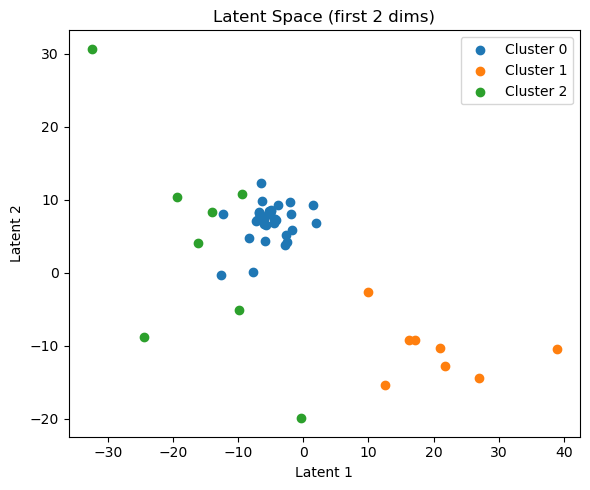

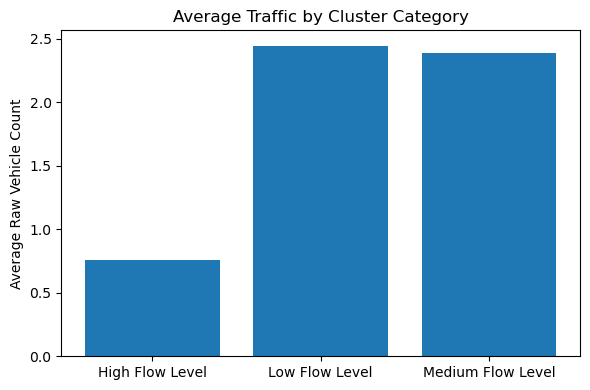

In [121]:
# plotting the latent scatter for the first 2 dimensions
if z.shape[1] >= 2:
    plt.figure(figsize=(6,5))
    for c in range(3):
        mask = (cluster_labels == c)
        plt.scatter(z[mask, 0], z[mask, 1], label=f"Cluster {c}")
    plt.xlabel("Latent 1")
    plt.ylabel("Latent 2")
    plt.title("Latent Space (first 2 dims)")
    plt.legend()
    plt.tight_layout()
    plt.show()

cats = []
means = []
for c in range(3):
    cats.append(cluster_to_category[c])
    means.append(cluster_to_avg[c])

plt.figure(figsize=(6,4))
plt.bar(cats, means)
plt.ylabel("Average Raw Vehicle Count")
plt.title("Average Traffic by Cluster Category")
plt.tight_layout()
plt.show()